# Introduction

- In this notebook I want to segment the customers by their individual data, using an unsupervise learning algorithm to help us find patterns in an unlabelled data.

- This method is often used to help understand the profile of users so that company can strategize communication and campaigns better.

- The dataset can be obtained from https://archive.ics.uci.edu/dataset/222/bank+marketing

## Import Libraries and Dataset

In [17]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from kmodes.kmodes import KModes

In [5]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Identify a single customer using combination of `age` `job` `marital` `education` `default` `housing` `loan`.  
Get all the columns and get rid of the others.

In [6]:
df = df[["age", "job", "marital", "education", "default", "housing", "loan"]]
df.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


In [8]:
# Dataframe shape

print("columns: ", df.shape[1])
print("rows: ", df.shape[0])

columns:  7
rows:  41188


One customer may have multiple rows for different activity.

In [10]:
df.duplicated().sum()

28182

Because my main goal is to segment each customer, I want to get distinct customer by the combination of `age`, `job`, `marital`, `education`, `default`, `housing`, and `loan`.

In [11]:
df.drop_duplicates(inplace=True)

Check for null value.

In [12]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
housing      0
loan         0
dtype: int64

To be able to do any calculatin with segmemtation algorithm (K-Mode method), I need to make sure that the numerical columns are either type `int64` or `float` and that the categorical columns are type `category`.


In [13]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
housing      object
loan         object
dtype: object

The dataset has one numeric variable, `age`, and six categorical variables.

In [14]:
# List categorical columns
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Loop each element within the list to be changed into the type `category`
for col in cat_cols:
    df[col] = df[col].astype('category')

# Check data types again
df.dtypes

age             int64
job          category
marital      category
education    category
default      category
housing      category
loan         category
dtype: object

Check unique values of each categorical column.

In [15]:
for col in cat_cols:
    print(f'{col}:')
    print(df[col].unique())
    print('\n')

job:
['housemaid', 'services', 'admin.', 'blue-collar', 'technician', ..., 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student', 'technician', 'unemployed', 'unknown']


marital:
['married', 'single', 'divorced', 'unknown']
Categories (4, object): ['divorced', 'married', 'single', 'unknown']


education:
['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
Categories (8, object): ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown']


default:
['no', 'unknown', 'yes']
Categories (3, object): ['no', 'unknown', 'yes']


housing:
['no', 'yes', 'unknown']
Categories (3, object): ['no', 'unknown', 'yes']


loan:
['no', 'yes', 'unknown']
Categories (3, object): ['no', 'unknown', 'yes']




- For the `age` column, I also want to convert it from `numerical` into `categorical`.

- This can be achieved by binning the values within the column. To decide how many bins, we can first explore the data visually.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



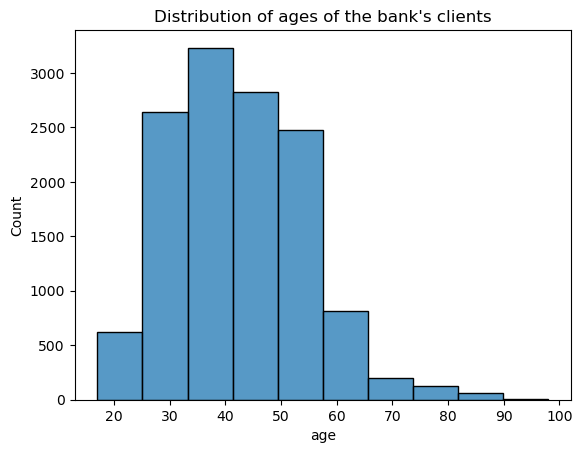

In [23]:
# Draw plot
sns.histplot(data=df,
             x='age',
             bins=10 # Playaround with different bins number
             )

# Add title
plt.title("Distribution of ages of the bank's clients")

# Add label
plt.ylabel('Count')

# Show the plot
plt.show()

# Clustering using K-Modes

- In this step, I want to feed the data that we have into K-Modes algorithm.

- The goal is to cluster 7 categorical columns.

- The K-Modes algorithm is a modification of K-Means more suited for categorical data. Instead of calculating the Euclidean distance between the datapoints and cluster centers, in K-Modes, a dissimilarity measure is used, which is defined as the number of features of the datapoint whose values do not match those of the cluster center. Also, the cluster centers are updated using the mode of the datapoints assigned to each cluster, instead of the mean.


In [24]:
data_kmodes = df.copy()
data_kmodes.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


Decided how many bins to convert the `age` column into, we can do so and input the result into a new column called `data_kmodes` using `pd.cut()`.

In [25]:
# Bin `age` column into 10 bins from 10 to 100, change type into category
data_kmodes['age_binned'] = pd.cut(data_kmodes['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype('category')

# Drop `age` column
data_kmodes.drop('age', axis=1, inplace=True)

# Show first 5 rows
data_kmodes.head()

,job,marital,education,default,housing,loan,age_binned
0,housemaid,married,basic.4y,no,no,no,"(50, 60]"
1,services,married,high.school,unknown,no,no,"(50, 60]"
2,services,married,high.school,no,yes,no,"(30, 40]"
3,admin.,married,basic.6y,no,no,no,"(30, 40]"
4,services,married,high.school,no,no,yes,"(50, 60]"


## One-hot encoding

- One-hot encoding converts categorical variables into a set of binary columns, each representing a unique category.  
- For instance, a "Color" variable with values "Red", "Green", and "Blue" becomes three columns: "Color_Red", "Color_Green", and "Color_Blue".   
- Each row has a 1 in the column corresponding to its category and 0s in the others, allowing algorithms to process categorical data without assuming any order.


In [26]:
data_kmodes.head()

,job,marital,education,default,housing,loan,age_binned
0,housemaid,married,basic.4y,no,no,no,"(50, 60]"
1,services,married,high.school,unknown,no,no,"(50, 60]"
2,services,married,high.school,no,yes,no,"(30, 40]"
3,admin.,married,basic.6y,no,no,no,"(30, 40]"
4,services,married,high.school,no,no,yes,"(50, 60]"


In [27]:
print(data_kmodes.shape)

(13006, 7)


In [28]:
data_kmodes = pd.get_dummies(data_kmodes, drop_first=True)
data_kmodes.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,loan_unknown,loan_yes,"age_binned_(20, 30]","age_binned_(30, 40]","age_binned_(40, 50]","age_binned_(50, 60]","age_binned_(60, 70]","age_binned_(70, 80]","age_binned_(80, 90]","age_binned_(90, 100]"
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,False


In [29]:
print(data_kmodes.shape)

(13006, 35)


## Feeding the Data into the Algorithm

- Now that the data is ready, I can feed it to the algorithm.

- To find the number of clusters, I need to simulate different scenarios. In this case, I want to simulate what would happen if I cluster the data into 2 to 8 clusters.

- The algorithm will then loop around the simulation per cluster and save the `Cost` for each cluster.

- The cost of the K-Modes algorithm is defined as the sum of the dissimilarities of each datapoint.

- Aim to find clusters with low `Cost`.

- But if I choose the biggest possible number of cluster, it will cost us a lot in processing power and time.

- So I should aim for the sweet spot where I get low `Cost` and quick processing time.

- This is where the `elbow method` comes in. Find the number of cluster where the diminishing value of `Cost` starts to get lower.

In [30]:
# Running the K-Modes algorithm for different numbers of clusters:

n_clusters = list(range(2, 9))
costs = []

for n in n_clusters:
    kmodes = KModes(n_clusters=n, init='random', n_init=10, max_iter=500, random_state=42)
    kmodes.fit(data_kmodes)
    cost = kmodes.cost_
    costs.append(cost)

Plot `cost` vs `number of cluster`.

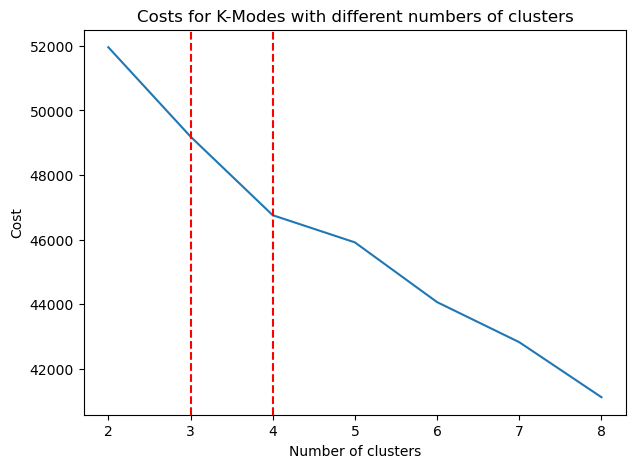

In [31]:
# Plotting the cost:

plt.figure(figsize=(7,5))
plt.plot(n_clusters, costs)
plt.axvline(3, linestyle='--', c='r')
plt.axvline(4, linestyle='--', c='r')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Costs for K-Modes with different numbers of clusters')
plt.show()

Choose 4 clusters based on the elbow method.

## Label the Original Data

In [32]:
kmodes = KModes(n_clusters=4, init='random', n_init=10, max_iter=500, random_state=42)
df['cluster_k-modes'] = kmodes.fit_predict(data_kmodes)

## Explore Each Variable from Every Cluster

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



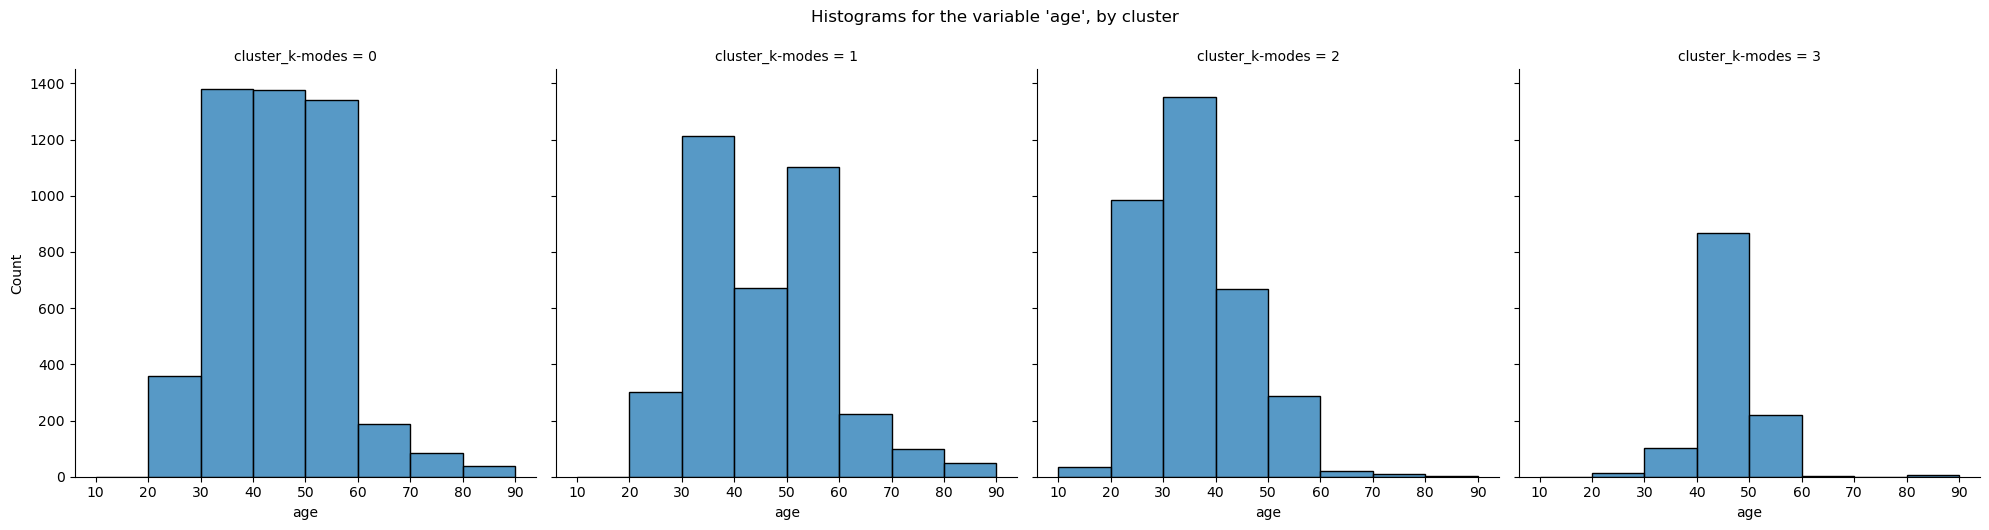

In [33]:
g = sns.displot(data=df,
                x='age',
                col='cluster_k-modes',
                bins=[10, 20, 30, 40, 50, 60, 70, 80, 90]
                )

g.fig.suptitle("Histograms for the variable 'age', by cluster", y=1.05)

plt.show()

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



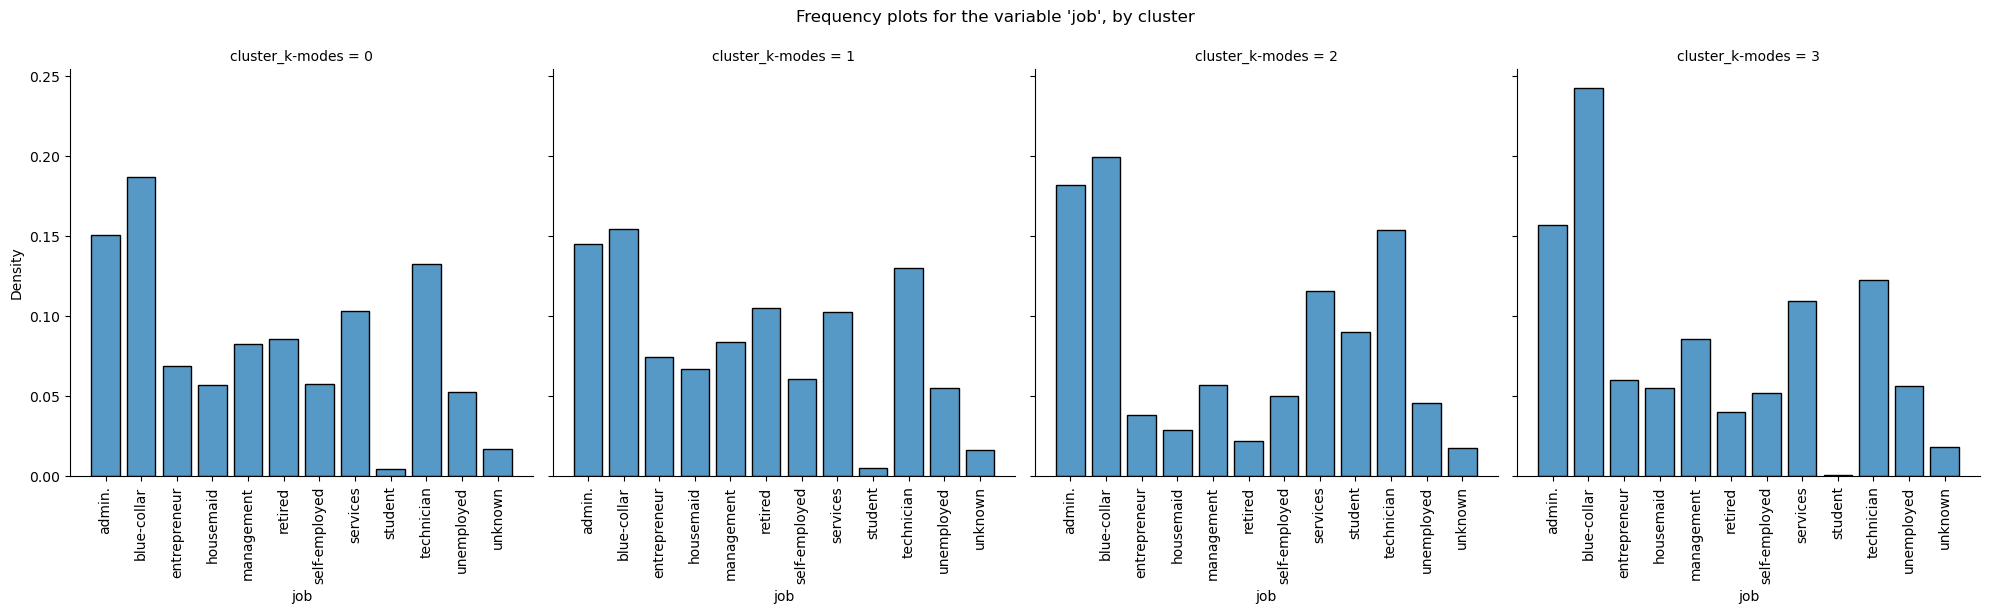

In [34]:
g = sns.displot(data=df,
                x='job',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)

plt.show()

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



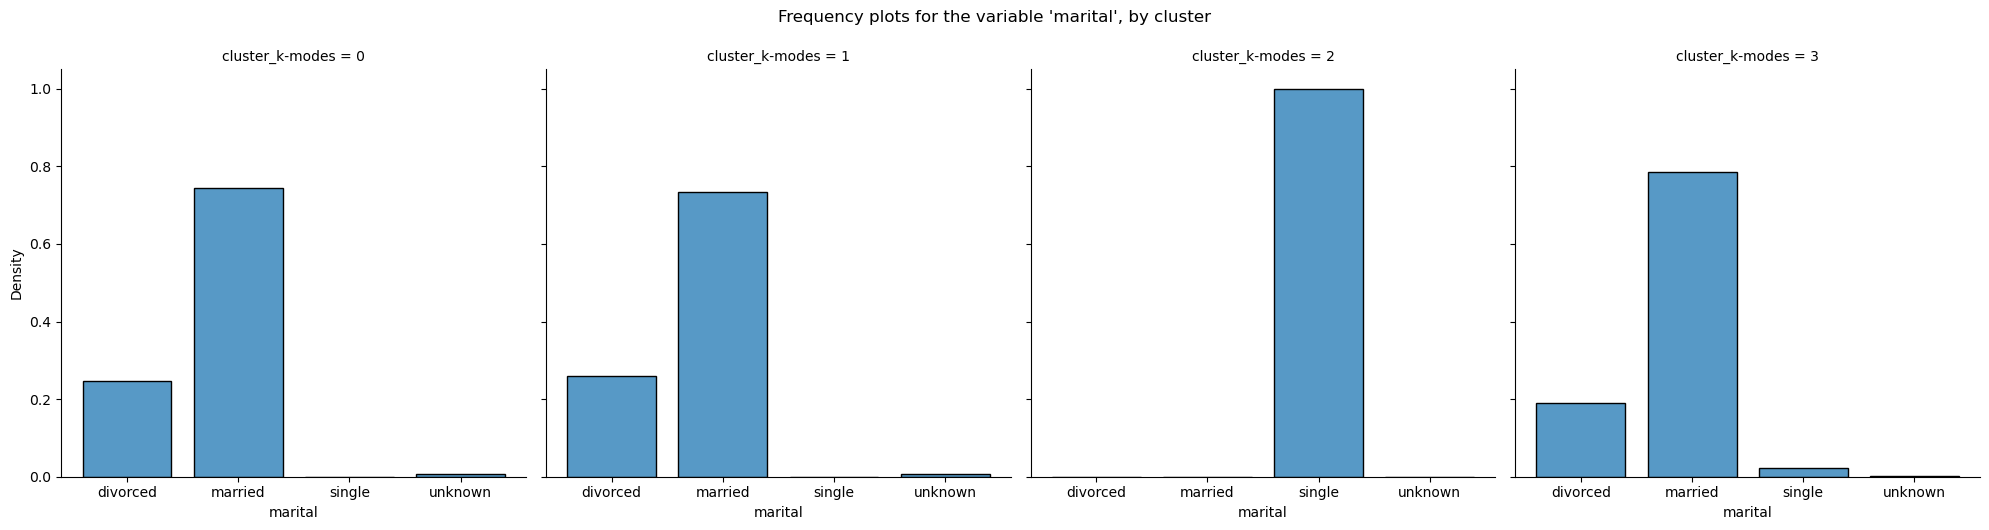

In [35]:
g = sns.displot(data=df,
                x='marital',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'marital', by cluster", y=1.05)

plt.show()

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



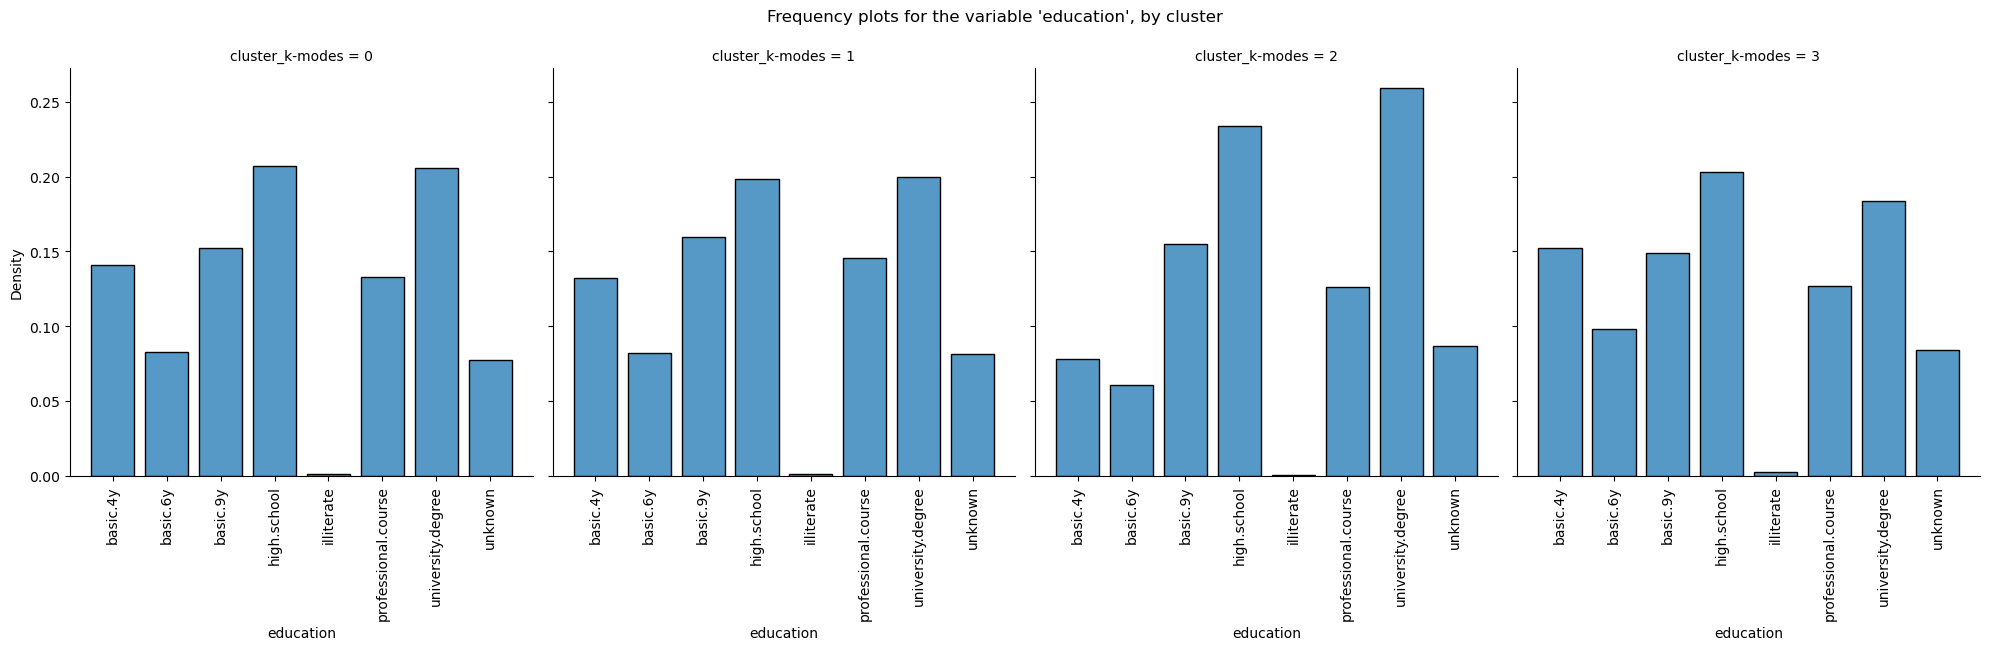

In [36]:
g = sns.displot(data=df,
                x='education',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'education', by cluster", y=1.05)

plt.show()

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



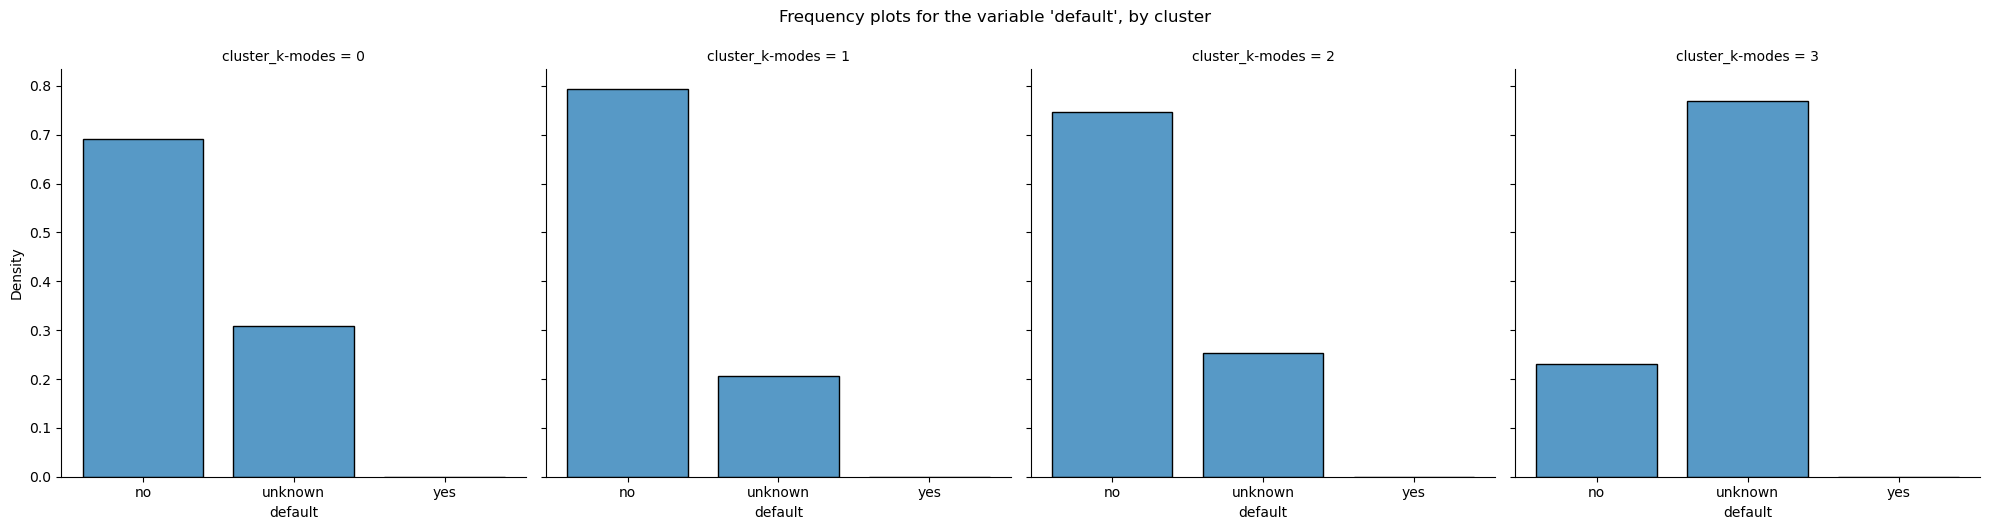

In [37]:
g = sns.displot(data=df,
                x='default',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'default', by cluster", y=1.05)

plt.show()

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



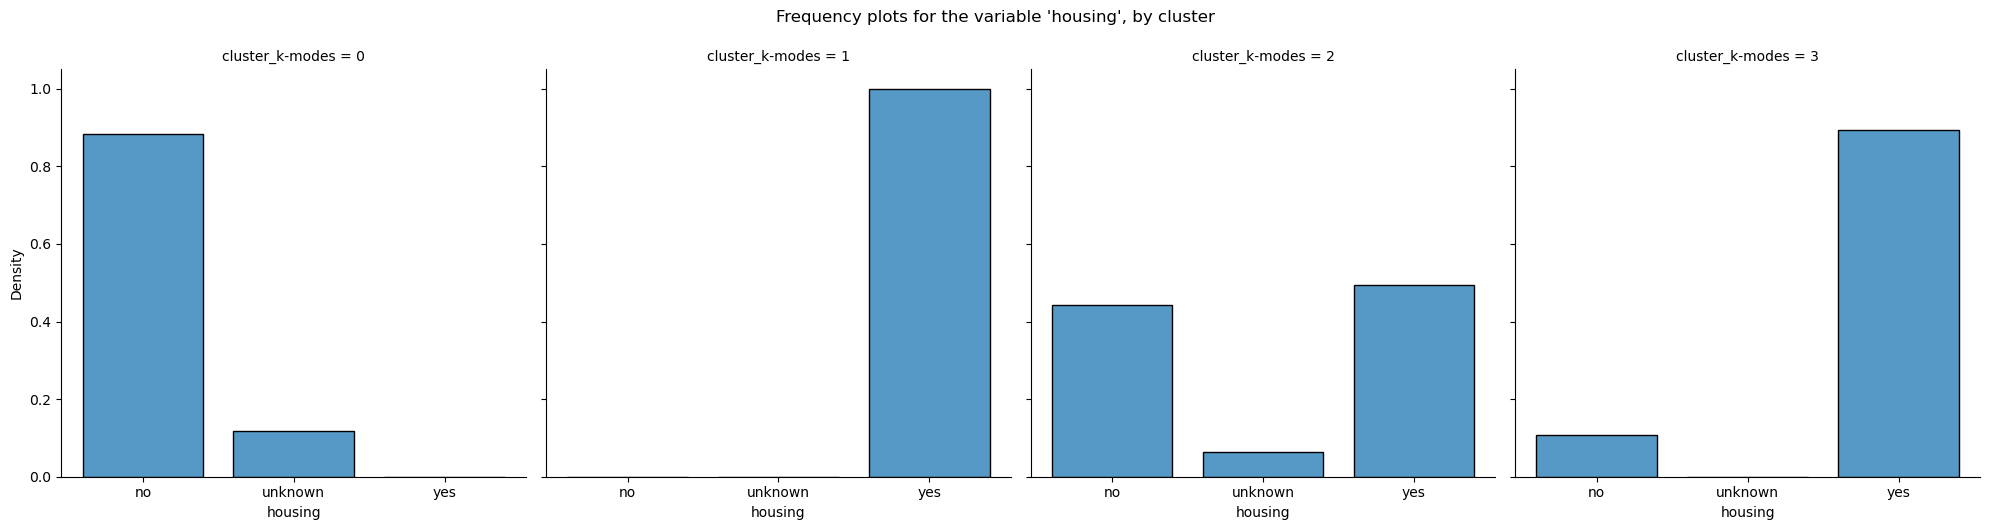

In [38]:
g = sns.displot(data=df,
                x='housing',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'housing', by cluster", y=1.05)

plt.show()

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vince\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



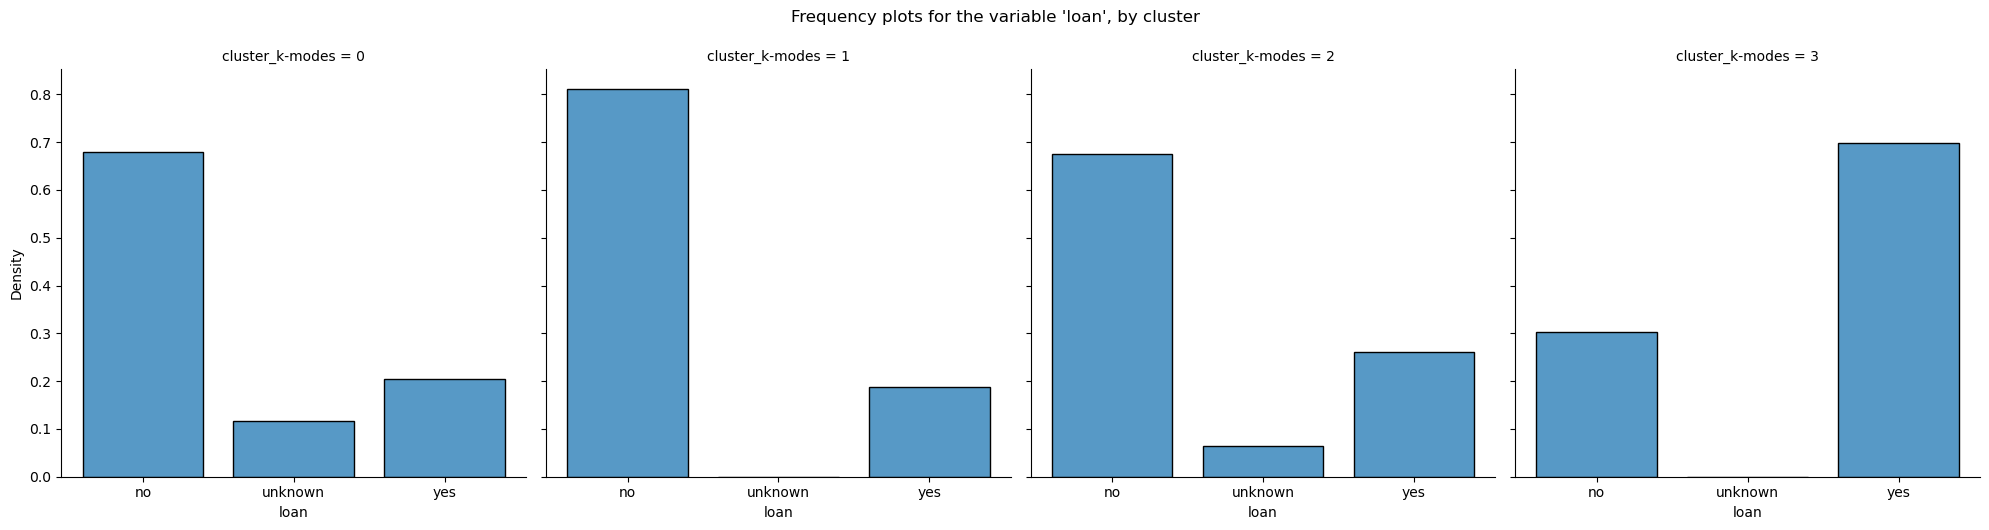

In [39]:
g = sns.displot(data=df,
                x='loan',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'loan', by cluster", y=1.05)

plt.show()

| Variable |1 |2 | 3| 4|
|-|-|-|-|-|
|`age`| 30-60 | 30-60 | 20-40 | 40-50 |
|`job`| admin, blue-collar, technician | admin, blue-collar, technician | services, student | admin, blue-collar, technician|
|`marital`| divorced, married | divorced, married | single | divorced, married |
|`education`| high-school, university | high-school, university | high-school, university | high-school, university |
|`default`| no | no | no | unknown default |
|`housing`| no | yes | no, yes | yes |
|`loan`| no | no | no | yes |